In [1]:
import sys
import os
# Path to the folder of the stand-alone model on your machine
path = r'/Users/MuhammadAwais/Reps/MESSAGEix-CA/'
file = 'MESSAGE_CA__test__v4.xlsx'
# Path to subfolder for the stand-alone model data (Excel files)
os.chdir(path)
print(os.getcwd())
sys.path.insert(1, path)


/Users/MuhammadAwais/Reps/MESSAGEix-CA


In [2]:
import message_ix
import ixmp as ix
from ixmp import Scenario


# Stand-alone model
modelName = 'MESSAGEix_CA'      # A MESSAGE model name
scenarioName = 'baseline'       # A MESSAGE model scenario name

mp = ix.Platform()
# mp2 = ix.Platform(dbtype='HSQLDB')

# Notic: either choose I or II
# I) Creating a new MESSAGE stand-alone model
msg = message_ix.Scenario(mp, modelName, scenarioName,
                            version='new', annotation='')


In [3]:

msg.read_excel(path = path + file, init_items = True,
              commit_steps=False)

Cannot read set 'is_relation_lower_time': index set(s) cannot be inferred for name(s) ['node_rel', 'year_rel']
Cannot read set 'is_relation_upper_time': index set(s) cannot be inferred for name(s) ['node_rel', 'year_rel']


In [4]:
growth = msg.par('growth_activity_up')
growth.head()

node_loc technology  year_act  time  value unit
0   Canada    LNG_exp      2010  year   0.06    %
1   Canada    LNG_exp      2020  year   0.06    %
2   Canada    LNG_exp      2030  year   0.06    %
3   Canada    LNG_exp      2040  year   0.06    %
4   Canada    LNG_exp      2050  year   0.06    %

In [23]:
 msg.check_out()

In [7]:
# demand = msg.par('demand',{'commodity':'rc_therm'})
# demand.head()

In [8]:
# msg.remove_par('demand', demand)

In [9]:
# demand['value'] = demand['value'] * 0.75

In [10]:
# msg.add_par('demand',demand)

In [24]:

growth_gas = growth[growth['technology'].str.contains('gas')]
msg.remove_par('growth_activity_up', growth_gas)
growth_gas['value'] = growth_gas['value'] * 3
msg.add_par('growth_activity_up', growth_gas)

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
growth_gas_lo = msg.par('growth_activity_lo')
growth_gas_lo = growth_gas_lo[growth_gas_lo['technology'].str.contains('gas')]
msg.remove_par('growth_activity_lo', growth_gas_lo)
growth_gas_lo['value'] = growth_gas_lo['value'] * 3
msg.add_par('growth_activity_lo', growth_gas_lo)

In [14]:
# #msg.check_out()

# resource_1 = msg.par('resource_volume',{'commodity':'gas_1'})
# resource_2 = msg.par('resource_volume',{'commodity':'gas_2'})
# resource_3 = msg.par('resource_volume',{'commodity':'gas_3'})
# resource_4 = msg.par('resource_volume',{'commodity':'gas_4'})

In [15]:
# frames = [resource_1, resource_2, resource_3, resource_4]
# import pandas as pd
# resource = pd.concat(frames)

In [16]:
# resource

In [17]:
# #resource['value'] = resource['value'] *2.5 
# msg.add_par('resource_volume', resource)


In [18]:
msg.model

'MESSAGEix_CA'

In [22]:
msg.version

11

In [26]:
msg.commit('')

In [27]:

# Exporting the built model (Scenario) to GAMS with an optional case name
caseName = msg.model + '__' + msg.scenario + '__v' + str(msg.version)

# Solving the model
msg.solve(model='MESSAGE', case=caseName)


In [35]:
from message_ix.reporting import Reporter
import numpy as np
unit_correct = False  # unit s must be corrected to run this script
from_excel = False
min_year = 2020
max_year = 2060

In [36]:
if unit_correct:
    msg = msg.clone(keep_solution=False)
    unit_correction(mp, msg)
    caseName = msg.model + '__' + msg.scenario + '__v' + str(msg.version)
    # Solving the model
    scen.solve(model='MESSAGE', case=caseName, solve_options={'lpmethod': '4'})

#%% Generating reporter
rep = Reporter.from_scenario(msg)
report = rep.get('message:default') # in fact, only in = input x ACT, out = output x ACT is needed

if from_excel:
    # Read default report
    report_df = pd.read_csv('MESSAGE_NO_example_default_report.csv')
else:
# Or if trying another country model, execute the next 4:
    report_df = report.timeseries()
    report_df.reset_index(inplace=True)
    report_df.columns = report_df.columns.astype(str)
    report_df.columns = report_df.columns.str.title()


fix_cost: mixed units ['USD/GWa', 'USD/kWa'] discarded
inv_cost: mixed units ['USD/GWa', 'USD/kWa'] discarded
input: mixed units ['GWa', '-', '%'] discarded
output: mixed units ['GWa', '-', '%'] discarded
emission_factor: mixed units ['tC', '???', 'kg/kWa', '-'] discarded


In [37]:
# Plotted years
years = msg.set('year').tolist()
years = [str(x) for x in years if x > min_year and x <= max_year]

# Create data for Sankey diagrams and plot it using plotly
report_df.fillna(0, inplace = True)

# Convert from GWa to TWh (*8.76)
c = report_df.select_dtypes(include=[np.number]) * 8.76
report_df[c.columns] = c

# Drop not necessary years
report_df.columns = report_df.columns.astype(str)
report_df = report_df.drop(report_df.columns.to_series()['2020': str(min_year)],
                           axis=1)

# Identify input and output variables and its flows (provided within the Reporter: in = input x ACT, out = output x ACT)
in_flows = report_df[report_df['Variable'].str.startswith("in|")]
out_flows = report_df[report_df['Variable'].str.startswith("out|")]
all_flows = out_flows.append(in_flows)

In [38]:
report_df.to_csv('MESSAGE_CANADA.csv')

In [39]:
report_df

Model  Scenario        Region                  Variable Unit  \
0     MESSAGEix_CA  baseline        Canada          capacity|LNG_exp        
1     MESSAGEix_CA  baseline        Canada   capacity|adipic_thermal        
2     MESSAGEix_CA  baseline        Canada  capacity|ammonia_secloop        
3     MESSAGEix_CA  baseline        Canada          capacity|bio_hpl        
4     MESSAGEix_CA  baseline        Canada     capacity|bio_hpl__air        
...            ...       ...           ...                       ...  ...   
3349  MESSAGEix_CA  baseline  Canada|World  out|stocks|puq|nuc_lc|M1        
3350  MESSAGEix_CA  baseline  Canada|World  out|stocks|u5q|nuc_hc|M1        
3351  MESSAGEix_CA  baseline  Canada|World  out|stocks|u5q|nuc_lc|M1        
3352  MESSAGEix_CA  baseline  Canada|World   out|stocks|uq|nuc_hc|M1        
3353  MESSAGEix_CA  baseline  Canada|World   out|stocks|uq|nuc_lc|M1        

      1950  1955  1960  1965  1970  ...  2010  2015      2025      2030  \
0      0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  6.927826  12.23385   
1      0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   
2      0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   
3      0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   
4      0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   
...    ...   ...   ...   ...   ...  ...   ...   ...       ...       ...   
3349   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   
3350   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   
3351   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   
3352   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   
3353   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0  0.000000   0.00000   

           2035       2040       2045      2050       2055        2060  
0     19.334507  28.836788  41.552983  58.57012  81.342889  111.817991  
1      0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  
2      0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  
3      0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  
4      0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  
...         ...        ...        ...       ...        ...         ...  
3349   0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  
3350   0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  
3351   0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  
3352   0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  
3353   0.000000   0.000000   0.000000   0.00000   0.000000    0.000000  

[3354 rows x 27 columns]

In [137]:
report_df["Variable"] = report_df["Variable"].str.replace('emis', 'Emissions', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('in|final|', 'Final Energy|', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('out|final|', 'Final Energy|', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('in|primary|', 'Primary Energy|', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('out|primary|', 'Primary Energy|', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('in|renewable|', 'Primary Energy|renewable|', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('out|renewable|', 'Primary Energy|renewable|', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('total om cost|', 'Total Costs|', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('out|useful|', 'Useful Energy|', regex = False)
report_df["Variable"] = report_df["Variable"].str.replace('in|useful|', 'Useful Energy|', regex = False)
# report_df1["Variable"] = report_df1["Variable"].str.replace('emis', 'Emissions', regex = False)
# report_df1["Variable"] = report_df1["Variable"].str.replace('in|final|', 'Final Energy|', regex = False)
# report_df1["Variable"] = report_df1["Variable"].str.replace('in|primary|', 'Primary Energy|', regex = False)
# report_df1["Variable"] = report_df1["Variable"].str.replace('total om cost|', 'Total Costs|', regex = False)
# report_df1["Variable"] = report_df1["Variable"].str.replace('in|renewable|', 'Primary Energy|renewable|', regex = False)
# report_df1["Variable"] = report_df1["Variable"].str.replace('out|useful|', 'Useful Energy|', regex = False)

In [138]:
import pyam
import matplotlib.pyplot as plt
import pyam
plotyrs = [2020,2025,2030,2035,2040,2045,2050,2055,2060]
pyam_df = pyam.IamDataFrame(report_df)
pdf = pyam_df.copy()

In [180]:

biomass = ['Primary Energy|biomass|bio_istig_ccs|M1', 
'Primary Energy|biomass|bio_istig|M1',
'Primary Energy|biomass|bio_ppl|M1',
'Primary Energy|biomass|biomass_nc|M1',
'Primary Energy|biomass|biomass_t_d|M1',
'Primary Energy|biomass|eth_bio_ccs|M1',
'Primary Energy|biomass|eth_bio|M1',
'Primary Energy|biomass|gas_bio|M1',
'Primary Energy|biomass|h2_bio_ccs|M1',
'Primary Energy|biomass|h2_bio|M1',
'Primary Energy|biomass|liq_bio_ccs|M1',
'Primary Energy|biomass|liq_bio|M1','Primary Energy|biomass|land_use_biomass|M1']

lng = 'Primary Energy|LNG|LNG_bal|M1'

coal = ['Primary Energy|coal|coal_bal|M1',
                      'Primary Energy|coal|coal_exp|M1',
                      'Primary Energy|coal|coal_exp|M1',
                      'Primary Energy|coal|coal_extr_ch4|M1',
                      'Primary Energy|coal|coal_extr|M1',
                      'Primary Energy|coal|lignite_extr|M1']
gas = ['Primary Energy|gas|gas_bal|M1','Primary Energy|gas|gas_extr_1|M1',
      'Primary Energy|gas|gas_extr_2|M1',
      'Primary Energy|gas|gas_extr_3|M1',
      'Primary Energy|gas|gas_extr_4|M1',
      'Primary Energy|gas|gas_extr_5|M1',
      'Primary Energy|gas|gas_extr_6|M1',
      'Primary Energy|gas|LNG_prod|M1',
       'Primary Energy|LNG|LNG_bal|M1']

oil = ['Primary Energy|crudeoil|oil_bal|M1', 'Primary Energy|crudeoil|oil_exp|M1',
      'Primary Energy|crudeoil|oil_extr_1_ch4|M1',
        'Primary Energy|crudeoil|oil_extr_1|M1',
        'Primary Energy|crudeoil|oil_extr_2_ch4|M1',
        'Primary Energy|crudeoil|oil_extr_2|M1',
        'Primary Energy|crudeoil|oil_extr_3_ch4|M1',
        'Primary Energy|crudeoil|oil_extr_3|M1',
        'Primary Energy|crudeoil|oil_extr_4_ch4|M1',
        'Primary Energy|crudeoil|oil_extr_4|M1',
        'Primary Energy|crudeoil|oil_extr_5|M1',
        'Primary Energy|crudeoil|oil_extr_6|M1',
        'Primary Energy|crudeoil|oil_extr_7|M1']

hydro = ['Primary Energy|renewable|hydro|hydro_hc|M1',  'Primary Energy|renewable|hydro|hydro_lc|M1']

biomass_renew = ['Primary Energy|renewable|biomass|bio_extr_a|M1',
                'Primary Energy|renewable|biomass|bio_extr_b|M1',
                'Primary Energy|renewable|biomass|bio_extr_c|M1',
                'Primary Energy|renewable|biomass|bio_extr_d|M1',
                'Primary Energy|renewable|biomass|bio_extr_e|M1',
                'Primary Energy|renewable|biomass|bio_extr_f|M1',
                'Primary Energy|renewable|biomass|bio_extr_g|M1']

solar = ['Primary Energy|renewable|solar_pv|solar_pv_ppl|M1' , 
         'Primary Energy|renewable|solar_th|solar_th_ppl|M1']


wind = ['Primary Energy|renewable|wind|wind_ppf|M1', 'Primary Energy|renewable|wind|wind_ppl|M1']

lh2 = ['Primary Energy|lh2|lh2_bal|M1', 'Primary Energy|lh2|lh2_exp|M1']

ethanol = ['Primary Energy|methanol|meth_bal|M1',  'Primary Energy|methanol|meth_exp|M1']

methanol = ['Primary Energy|ethanol|eth_bal|M1', 'Primary Energy|ethanol|eth_exp|M1']

In [181]:
pdf = pyam_df.copy()
pdf_coal = pdf.filter(variable = ['Primary Energy|coal|coal_bal|M1',
                      'Primary Energy|coal|coal_exp|M1',
                      'Primary Energy|coal|coal_exp|M1',
                      'Primary Energy|coal|coal_extr_ch4|M1',
                      'Primary Energy|coal|coal_extr|M1',
                      'Primary Energy|coal|lignite_extr|M1'],year = plotyrs)

In [182]:
pdf.aggregate(
    "Primary Energy|coal",
    components=coal,
    append=True
)


pdf.aggregate(
    "Primary Energy|solar",
    components=solar,
    append=True
)

pdf.aggregate(
    "Primary Energy|hydro",
    components=hydro,
    append=True
)

pdf.aggregate(
    "Primary Energy|ethanol",
    components=ethanol,
    append=True
)
pdf.aggregate(
    "Primary Energy|methanol",
    components=methanol,
    append=True
)
pdf.aggregate(
    "Primary Energy|Liq. Hydrogen",
    components=lh2,
    append=True
)
pdf.aggregate(
    "Primary Energy|wind",
    components=wind,
    append=True
)

pdf.aggregate(
    "Primary Energy|biomass",
    components= biomass,
    append=True
)

pdf.aggregate(
    "Primary Energy|oil",
    components=oil,
    append=True
)

pdf.aggregate(
    "Primary Energy|gas",
    components=gas,
    append=True
)

pdf.aggregate(
    "Primary Energy|LNG",
    components=lng,
    append=True
)

pyam.utils - WARNING: Formatted data is empty!
pyam.utils - WARNING: Formatted data is empty!


In [176]:
coal = pdf.filter(variable = 'Primary Energy|gas',year = plotyrs)

In [178]:
gas.head()

AttributeError: 'list' object has no attribute 'head'

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `IamDataFrame.plot.stack()`.
  


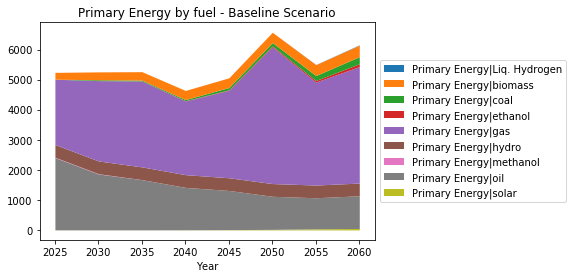

In [184]:
pdf.filter(scenario = 'baseline', variable=["Primary Energy|solar",
                                            #"Primary Energy|LNG",
                                            "Primary Energy|gas",
                                            "Primary Energy|oil",
                                            "Primary Energy|biomass",
                                            "Primary Energy|wind",
                                            "Primary Energy|Liq. Hydrogen",
                                            "Primary Energy|methanol",
                                            "Primary Energy|ethanol",
                                            "Primary Energy|hydro",
                                            "Primary Energy|methanol",
                                           "Primary Energy|coal"],
              year = plotyrs).stack_plot(total=False,
                                        title = 'Primary Energy by fuel - Baseline Scenario')

In [112]:
gas = pyam_df.filter(scenario = 'baseline', variable=[
                                            "Primary Energy|gas",
                                            ],
              year = plotyrs)

pyam.core - WARNING: Filtered IamDataFrame is empty!


In [106]:
gas.head(10)

model  scenario         region            variable unit  year  \
0  MESSAGEix_CA  baseline  Canada|Canada  Primary Energy|gas       2025   
1  MESSAGEix_CA  baseline  Canada|Canada  Primary Energy|gas       2030   
2  MESSAGEix_CA  baseline  Canada|Canada  Primary Energy|gas       2035   
3  MESSAGEix_CA  baseline  Canada|Canada  Primary Energy|gas       2040   
4  MESSAGEix_CA  baseline  Canada|Canada  Primary Energy|gas       2045   
5  MESSAGEix_CA  baseline  Canada|Canada  Primary Energy|gas       2050   
6  MESSAGEix_CA  baseline  Canada|Canada  Primary Energy|gas       2055   
7  MESSAGEix_CA  baseline  Canada|Canada  Primary Energy|gas       2060   

         value  
0  1078.131690  
1     0.000000  
2     0.000000  
3  1196.980084  
4  1412.353610  
5     0.000000  
6  1631.356870  
7  1825.498806

In [62]:
i_feed = ['Useful Energy|i_feed|ethanol_fs|M1', 'Useful Energy|i_feed|gas_fs|M1',
         'Useful Energy|i_feed|loil_fs|M1', 'Useful Energy|i_feed|methanol_fs|M1']

transport = ['Useful Energy|transport|coal_trp|M1',
            'Useful Energy|transport|elec_trp|M1',
            'Useful Energy|transport|eth_fc_trp|M1',
            'Useful Energy|transport|eth_ic_trp|M1',
            'Useful Energy|transport|foil_trp|M1',
            'Useful Energy|transport|gas_trp|M1',
            'Useful Energy|transport|h2_fc_trp|M1',
            'Useful Energy|transport|loil_trp|M1',
            'Useful Energy|transport|meth_fc_trp|M1',
            'Useful Energy|transport|meth_ic_trp|M1']


i_spec = ['Useful Energy|i_spec|h2_fc_I|M1',
          'Useful Energy|i_spec|sp_coal_I|M1',
          'Useful Energy|i_spec|sp_el_I|M1',
          'Useful Energy|i_spec|sp_eth_I|M1',
          'Useful Energy|i_spec|sp_liq_I|M1',
          'Useful Energy|i_spec|sp_meth_I|M1']

i_therm =   ['Useful Energy|i_therm|biomass_i|M1',
            'Useful Energy|i_therm|coal_i|M1',
            'Useful Energy|i_therm|elec_i|M1',
            'Useful Energy|i_therm|eth_i|M1',
            'Useful Energy|i_therm|foil_i|M1',
            'Useful Energy|i_therm|gas_i|M1',
            'Useful Energy|i_therm|h2_fc_I|M1',
            'Useful Energy|i_therm|h2_i|M1',
            'Useful Energy|i_therm|heat_i|M1',
            'Useful Energy|i_therm|hp_el_i|M1',
            'Useful Energy|i_therm|hp_gas_i|M1',
            'Useful Energy|i_therm|loil_i|M1',
            'Useful Energy|i_therm|meth_i|M1',
            'Useful Energy|i_therm|solar_i|M1']
rc_spec = ['Useful Energy|rc_spec|h2_fc_RC|M1',
          'Useful Energy|rc_spec|sp_el_RC|M1']

rc_therm = ['Useful Energy|rc_therm|biomass_rc|M1',
            'Useful Energy|rc_therm|coal_rc|M1',
            'Useful Energy|rc_therm|eth_rc|M1',
            'Useful Energy|rc_therm|foil_rc|M1',
            'Useful Energy|rc_therm|gas_rc|M1',
            'Useful Energy|rc_therm|h2_fc_RC|M1',
            'Useful Energy|rc_therm|h2_rc|M1',
            'Useful Energy|rc_therm|heat_rc|M1',
            'Useful Energy|rc_therm|hp_el_rc|M1',
            'Useful Energy|rc_therm|hp_gas_rc|M1',
            'Useful Energy|rc_therm|loil_rc|M1',
            'Useful Energy|rc_therm|meth_rc|M1',
            'Useful Energy|rc_therm|solar_rc|M1']

biom = ['Useful Energy|non-comm|biomass_nc|M1']

In [63]:
df_useful = pyam_df.copy()
# df_useful.aggregate(
#     "Useful Energy|non-Commercial biomass",
#     components=biom,
#     append=True
# )

df_useful.aggregate(
    "Useful Energy|residential/commercial thermal",
    components=rc_therm,
    append=True
)

df_useful.aggregate(
    "Useful Energy|residential/commercial specific",
    components=rc_spec,
    append=True
)

df_useful.aggregate(
    "Useful Energy|industrial thermal",
    components=i_therm,
    append=True
)

df_useful.aggregate(
    "Useful Energy|industrial specific",
    components=i_spec,
    append=True
)

df_useful.aggregate(
    "Useful Energy|industrial feedstock",
    components=i_feed,
    append=True
)

df_useful.aggregate(
    "Useful Energy|transport",
    components=i_therm,
    append=True
)


In [64]:
df_useful.filter(scenario = 'baseline', variable=[
    "Useful Energy|non-Commercial biomass",
    "Useful Energy|residential/commercial thermal",
    "Useful Energy|residential/commercial specific",
    "Useful Energy|industrial thermal",
    "Useful Energy|industrial specific",
    "Useful Energy|industrial feedstock",
    "Useful Energy|transport"],
              year = plotyrs).stack_plot(total=True,
                                         title = 'Demands by sector')

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `IamDataFrame.plot.stack()`.
  # Remove the CWD from sys.path while we load stuff.


In [130]:
cement = ['Emissions|CO2|cement_CO2|M1']
coal = ['Emissions|CO2|coal_extr_ch4|M1',
        'Emissions|CO2|coal_extr|M1',
        'Emissions|CO2|coal_imp|M1']
foil = ['Emissions|CO2|foil_imp|M1']
gas = ['Emissions|CO2|gas_extr_1|M1',
        'Emissions|CO2|gas_extr_2|M1',
        'Emissions|CO2|gas_extr_3|M1',
        'Emissions|CO2|gas_extr_4|M1',
        'Emissions|CO2|gas_extr_5|M1',
        'Emissions|CO2|gas_extr_6|M1'
        ]
lignite = ['Emissions|CO2|lignite_extr|M1']
loil = ['Emissions|CO2|loil_imp|M1']
meth_ccs = ['Emissions|CO2|meth_coal_ccs|M1']
oil = ['Emissions|CO2|oil_extr_1_ch4|M1',
    'Emissions|CO2|oil_extr_1|M1',
    'Emissions|CO2|oil_extr_2_ch4|M1',
    'Emissions|CO2|oil_extr_2|M1',
    'Emissions|CO2|oil_extr_3_ch4|M1',
    'Emissions|CO2|oil_extr_3|M1',
    'Emissions|CO2|oil_extr_4_ch4|M1',
    'Emissions|CO2|oil_extr_4|M1',
    'Emissions|CO2|oil_extr_5|M1',
    'Emissions|CO2|oil_extr_6|M1',
    'Emissions|CO2|oil_extr_7|M1']

oil_trade = ['Emissions|CO2|foil_imp|M1',
             'Emissions|CO2|loil_exp|M1',
            'Emissions|CO2|loil_imp|M1',
             'Emissions|CO2|oil_imp|M1']
       
gas_trade = ['Emissions|CO2|LNG_exp|M1',
            'Emissions|CO2|LNG_imp|M1',
            'Emissions|CO2|gas_imp|M1']
            #'Emissions|CO2|LNG_exp|M1']

In [131]:
df_emis_b = pyam_df.filter(variable = 'Emissions|CO2|*',year = plotyrs)

In [132]:
df_emis_b.to_csv('emissions.csv')

In [133]:
df_emis = pyam_df.copy()


df_emis.aggregate(
    "Emissions|CO2|gas",
    components=gas,
    append=True
)

df_emis.aggregate(
    "Emissions|CO2|oil",
    components=oil,
    append=True
)

df_emis.aggregate(
    "Emissions|CO2|coal",
    components=coal,
    append=True
)

df_emis.aggregate(
    "Emissions|CO2|cement",
    components=cement,
    append=True
)

df_emis.aggregate(
    "Emissions|CO2|oil trade",
    components=oil_trade,
    append=True
)

df_emis.aggregate(
    "Emissions|CO2|gas trade",
    components=gas_trade,
    append=True
)

In [136]:
df_emis.filter(scenario = 'baseline', variable=
    ["Emissions|CO2|gas",
    "Emissions|CO2|oil",
    "Emissions|CO2|coal",
    "Emissions|CO2|cement",
    "Emissions|CO2|oil trade",
    "Emissions|CO2|gas trade"],
              year = plotyrs).stack_plot(total=True,
                                         title = 'CO2 Emissions - Baseline Scenario')

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `IamDataFrame.plot.stack()`.
  if __name__ == '__main__':


In [186]:

coal = ['Total Costs|coal_adv',
        'Total Costs|coal_adv_ccs',
        'Total Costs|coal_bal',
        'Total Costs|coal_exp',
        'Total Costs|coal_extr',
        'Total Costs|coal_extr_ch4',
        'Total Costs|coal_gas',
        'Total Costs|coal_hpl',
        'Total Costs|coal_i',
        'Total Costs|coal_imp',
        'Total Costs|coal_ppl',
        'Total Costs|coal_ppl_u',
        'Total Costs|coal_rc',
        'Total Costs|coal_ppl',
        'Total Costs|coal_ppl_u',
       'Total Costs|coal_t_d',
       'Total Costs|syn_liq',
        'Total Costs|meth_coal',
       'Total Costs|lignite_extr']
biomass = ['bio_hpl', 'bio_ppl',
          'Total Costs|liq_bio']


elec = ['Total Costs|elec_exp',
        'Total Costs|elec_i',
        'Total Costs|elec_imp',
        'Total Costs|elec_t_d',
        'Total Costs|elec_trp']

oil = ['Total Costs|foil_i',
    'Total Costs|foil_imp',
    'Total Costs|foil_ppl',
    'Total Costs|oil_extr_1'
    'Total Costs|oil_extr_1_ch4'
    'Total Costs|oil_extr_2',
    'Total Costs|oil_extr_3',
    'Total Costs|oil_extr_4',
    'Total Costs|oil_extr_5',
    'Total Costs|oil_extr_6',
    'Total Costs|oil_extr_7',
    'Total Costs|oil_extr_2_ch4',
    'Total Costs|oil_extr_3_ch4',
    'Total Costs|loil_cc',
    'Total Costs|loil_ppl']
gas = ['Total Costs|gas_bal',
    'Total Costs|gas_bio',
    'Total Costs|gas_cc',
    'Total Costs|gas_cc_ccs',
    'Total Costs|gas_ct',
    'Total Costs|gas_extr_1',
    'Total Costs|gas_extr_2',
    'Total Costs|gas_extr_3',
    'Total Costs|gas_extr_4',
    'Total Costs|gas_extr_5',
    'Total Costs|gas_extr_6',
    'Total Costs|gas_extr_mpen',
    'Total Costs|gas_fs',
    'Total Costs|gas_hpl',
    'Total Costs|gas_i',
    'Total Costs|gas_imp',
    'Total Costs|gas_ppl',
    'Total Costs|gas_rc',
    'Total Costs|gas_t_d',
    'Total Costs|gas_t_d_ch4',
    'Total Costs|gas_trp',
      'Total Costs|igcc']

geo_ppl = ['Total Costs|geo_hpl','Total Costs|geo_ppl']

solar = ['Total Costs|solar_i',
        'Total Costs|solar_pv_ppl',
        'Total Costs|solar_rc',
        'Total Costs|solar_th_ppl']

wind = ['Total Costs|wind_curtailment1',
'Total Costs|wind_curtailment2',
'Total Costs|wind_curtailment3',
'Total Costs|wind_ppf',
'Total Costs|wind_ppl']

hydro = ['Total Costs|hydro_hc',
'Total Costs|hydro_lc']

nuclear = ['Total Costs|nuc_lc']


In [187]:
df_cost = pyam_df.copy()


df_cost.aggregate(
    "Total Costs|coal",
    components=coal,
    append=True
)

df_cost.aggregate(
    "Total Costs|biomass",
    components=biomass,
    append=True
)

df_cost.aggregate(
    "Total Costs|electricity",
    components=elec,
    append=True
)

df_cost.aggregate(
    "Total Costs|oil",
    components=biomass,
    append=True
)

df_cost.aggregate(
    "Total Costs|gas",
    components=gas,
    append=True
)

df_cost.aggregate(
    "Total Costs|geothermal",
    components=geo_ppl,
    append=True
)

df_cost.aggregate(
    "Total Costs|solar",
    components=solar,
    append=True
)

df_cost.aggregate(
    "Total Costs|wind",
    components=wind,
    append=True
)

df_cost.aggregate(
    "Total Costs|hydro",
    components=hydro,
    append=True
)
df_cost.aggregate(
    "Total Costs|nuclear",
    components=nuclear,
    append=True
)

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `IamDataFrame.plot.stack()`.
  if sys.path[0] == '':


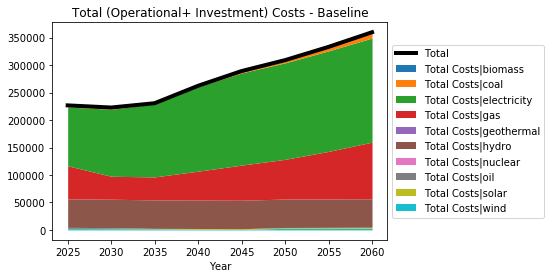

In [188]:
df_cost.filter(scenario = 'baseline', variable=
    ["Total Costs|coal","Total Costs|biomass",
    "Total Costs|electricity",
    "Total Costs|oil",
    "Total Costs|gas",
    "Total Costs|geothermal",
    "Total Costs|solar",
    "Total Costs|wind",
    "Total Costs|hydro",
    "Total Costs|nuclear"],
              year = plotyrs).stack_plot(total=True,
                                         title = 'Total (Operational+ Investment) Costs - Baseline')


In [190]:
import pandas as pd

In [192]:
copper = pd.read_csv('CRESTv4 Data_outputs_analyze_CRESTv4_data.csv')

In [194]:
copper.head(50)

Unnamed: 0   Model Scenario            Region          Variable Unit  \
0            0  COPPER    CTax0  British Columbia   capacity|gas cc   MW   
1            1  COPPER    CTax0  British Columbia   capacity|gas sc   MW   
2            2  COPPER    CTax0  British Columbia     capacity|coal   MW   
3            3  COPPER    CTax0  British Columbia  capacity|nuclear   MW   
4            4  COPPER    CTax0  British Columbia    capacity|hydro   MW   
5            5  COPPER    CTax0  British Columbia     capacity|wind   MW   
6            6  COPPER    CTax0  British Columbia    capacity|solar   MW   
7            7  COPPER    CTax0  British Columbia    capacity|waste   MW   
8            8  COPPER    CTax0  British Columbia   capacity|diesel   MW   
9            9  COPPER   CTax50  British Columbia   capacity|gas cc   MW   
10          10  COPPER   CTax50  British Columbia   capacity|gas sc   MW   
11          11  COPPER   CTax50  British Columbia     capacity|coal   MW   
12          12  COPPER   CTax50  British Columbia  capacity|nuclear   MW   
13          13  COPPER   CTax50  British Columbia    capacity|hydro   MW   
14          14  COPPER   CTax50  British Columbia     capacity|wind   MW   
15          15  COPPER   CTax50  British Columbia    capacity|solar   MW   
16          16  COPPER   CTax50  British Columbia    capacity|waste   MW   
17          17  COPPER   CTax50  British Columbia   capacity|diesel   MW   
18          18  COPPER  CTax100  British Columbia   capacity|gas cc   MW   
19          19  COPPER  CTax100  British Columbia   capacity|gas sc   MW   
20          20  COPPER  CTax100  British Columbia     capacity|coal   MW   
21          21  COPPER  CTax100  British Columbia  capacity|nuclear   MW   
22          22  COPPER  CTax100  British Columbia    capacity|hydro   MW   
23          23  COPPER  CTax100  British Columbia     capacity|wind   MW   
24          24  COPPER  CTax100  British Columbia    capacity|solar   MW   
25          25  COPPER  CTax100  British Columbia    capacity|waste   MW   
26          26  COPPER  CTax100  British Columbia   capacity|diesel   MW   
27          27  COPPER  CTax150  British Columbia   capacity|gas cc   MW   
28          28  COPPER  CTax150  British Columbia   capacity|gas sc   MW   
29          29  COPPER  CTax150  British Columbia     capacity|coal   MW   
30          30  COPPER  CTax150  British Columbia  capacity|nuclear   MW   
31          31  COPPER  CTax150  British Columbia    capacity|hydro   MW   
32          32  COPPER  CTax150  British Columbia     capacity|wind   MW   
33          33  COPPER  CTax150  British Columbia    capacity|solar   MW   
34          34  COPPER  CTax150  British Columbia    capacity|waste   MW   
35          35  COPPER  CTax150  British Columbia   capacity|diesel   MW   
36          36  COPPER  CTax200  British Columbia   capacity|gas cc   MW   
37          37  COPPER  CTax200  British Columbia   capacity|gas sc   MW   
38          38  COPPER  CTax200  British Columbia     capacity|coal   MW   
39          39  COPPER  CTax200  British Columbia  capacity|nuclear   MW   
40          40  COPPER  CTax200  British Columbia    capacity|hydro   MW   
41          41  COPPER  CTax200  British Columbia     capacity|wind   MW   
42          42  COPPER  CTax200  British Columbia    capacity|solar   MW   
43          43  COPPER  CTax200  British Columbia    capacity|waste   MW   
44          44  COPPER  CTax200  British Columbia   capacity|diesel   MW   
45          45  COPPER    CTax0           Alberta   capacity|gas cc   MW   
46          46  COPPER    CTax0           Alberta   capacity|gas sc   MW   
47          47  COPPER    CTax0           Alberta     capacity|coal   MW   
48          48  COPPER    CTax0           Alberta  capacity|nuclear   MW   
49          49  COPPER    CTax0           Alberta    capacity|hydro   MW   

        2020         2030          2050  
0     480.20  1411.176759   3692.836606  
1      46.00     0.000000      0.000000  
2

In [195]:
copper_df = pyam.IamDataFrame(copper)

In [198]:
copper.head()

Unnamed: 0   Model Scenario            Region          Variable Unit  \
0           0  COPPER    CTax0  British Columbia   capacity|gas cc   MW   
1           1  COPPER    CTax0  British Columbia   capacity|gas sc   MW   
2           2  COPPER    CTax0  British Columbia     capacity|coal   MW   
3           3  COPPER    CTax0  British Columbia  capacity|nuclear   MW   
4           4  COPPER    CTax0  British Columbia    capacity|hydro   MW   

       2020         2030         2050  
0    480.20  1411.176759  3692.836606  
1     46.00     0.000000     0.000000  
2      0.00     0.000000     0.000000  
3      0.00     0.000000     0.000000  
4  16577.33     0.000000     0.000000

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `IamDataFrame.plot.stack()`.
  This is separate from the ipykernel package so we can avoid doing imports until


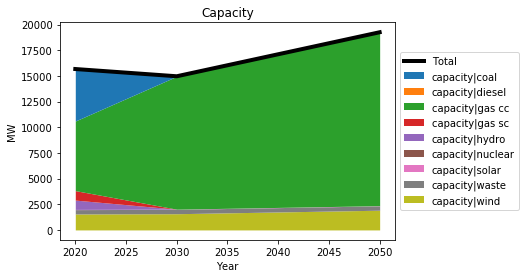

In [202]:
copper_df.filter(scenario = 'CTax200',
              region = 'Alberta' ,variable = 'capacity|*').stack_plot(total=True,
                                         title = 'Capacity')


In [206]:
alberta_ctax200_cap = copper_df.filter(scenario = 'CTax200',
              region = 'Alberta' ,variable = 'capacity|*')

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `IamDataFrame.plot.stack()`.
  after removing the cwd from sys.path.


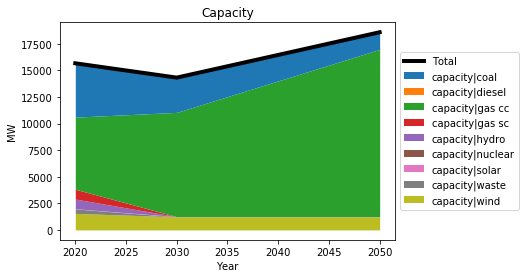

In [209]:
copper_df.filter(scenario = 'CTax0',
              region = 'Alberta' ,
                 variable = 'capacity|*').stack_plot(total=True,
                                         title = 'Capacity')


/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `IamDataFrame.plot.stack()`.
  This is separate from the ipykernel package so we can avoid doing imports until


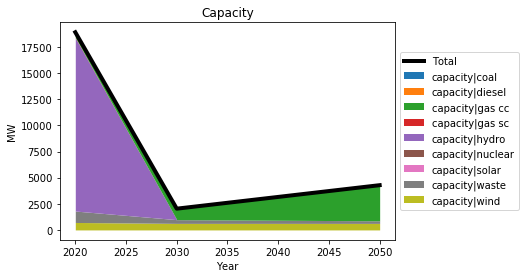

In [205]:
copper_df.filter(scenario = 'CTax200',
              region = 'British Columbia' ,variable = 'capacity|*').stack_plot(total=True,
                                         title = 'Capacity')
